In [2]:
## This is a test file to train to track an object
## Author : Avadesh Meduri
## Date : 8/04/2022

from matplotlib import pyplot as plt
import numpy as np

from torch.utils.data import Dataset
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision.io import read_image
from torch.utils.data import DataLoader, RandomSampler, Sampler
import time
from PIL import Image
from skimage.io import imread
import numba
from torchvision.transforms import ToTensor, ToPILImage, Resize


In [3]:
# i = np.random.randint(1000)
# box1 = ToTensor()(imread("./image_data/data1/color_" + str(i) + ".jpg"))
# box2 = ToTensor()(imread("./image_data/data1/depth_" + str(i) + ".jpg"))
# data = np.load("./position_data/" + "data10" + ".npz")
# print(box1.shape)
# plt.imshow(ToPILImage()(box1))
# plt.show()
# plt.imshow(ToPILImage()(box2))
# plt.show()
# print(data["position"][i])

In [4]:
class BoxDataSet(Dataset):
    
    def __init__(self, fname):
        
        self.img_dir = "./image_data/" + fname
        self.data = np.load("./position_data/" + fname + ".npz")
        self.y_train = torch.tensor(self.data["position"]).float()
    
    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, idx):
        
        c_image = ToTensor()(imread(self.img_dir + "/color_" + str(idx) + ".jpg"))
        d_image = ToTensor()(imread(self.img_dir + "/depth_" + str(idx) + ".jpg"))
        image = torch.vstack((c_image, d_image))
        label = self.y_train[idx]
        return image.float(), label
    
    def get_data(self, idx):
    
        c_image = ToTensor()(imread(self.img_dir + "/color_" + str(idx) + ".jpg"))
        d_image = ToTensor()(imread(self.img_dir + "/depth_" + str(idx) + ".jpg"))
        image = torch.vstack((c_image, d_image))[None,:,:,:]
        label = self.y_train[idx]
        
        return image.float(), label, c_image



In [5]:
# class C_Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(4, 3, 3)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(3, 3, 3)
#         self.conv3 = nn.Conv2d(3, 3, 3)
#         self.fc1 = nn.Linear(4284, 128)
#         self.fc2 = nn.Linear(128, 128)
#         self.fc3 = nn.Linear(128, 3)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
# #         print(x.shape)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [6]:
class C_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 32, 3)
        self.conv3 = nn.Conv2d(32, 16, 3)
        self.fc1 = nn.Linear(22848, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
def read_data(indices):
    dl_arr = []
    for i in range(len(indices)):
        print("loading", str(int(indices[i])), end = "\r", flush = False)
        dl_arr.append(DataLoader(BoxDataSet("data" + str(int(indices[i]))), batch_size = 64, num_workers = 12))
    return dl_arr

In [8]:
device = torch.device("cuda")
net = C_Net()
net.load_state_dict(torch.load("./models/cnn2"))
net = net.to(device)
lr = 1.0e-4
eps = 1000
indices = [1,2,3,4,5]
num_data = len(indices)
start = 1
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = torch.nn.MSELoss() #torch.nn.MSELoss() #torch.nn.HuberLoss()
dl_arr = read_data(indices)

In [ ]:
for i in range(eps):
#     if i % 2 == 0:
#         indices = torch.randperm(6)[:num_data] + 1
#         dl_arr = read_data(indices)

    for x_train_batch, y_train_batch in dl_arr[np.random.randint(num_data)]:
        x_train_gpu = x_train_batch.to(device)
        y_train_gpu = y_train_batch.to(device)
        y_pred = net(x_train_gpu)
        error = loss(y_pred, y_train_gpu) 
        print("The iteration number : " + str(i) + " The loss is :" + str(error.cpu().detach().numpy()), end='\r', flush  = True)
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
        
    if i % 10 == 0:
        torch.save(net.state_dict(), "./models/cnn2")
        
torch.save(net.state_dict(), "./models/cnn2")    

In [40]:
dl = BoxDataSet("data3")
net = C_Net()
net.load_state_dict(torch.load("./models/cnn2"))

<All keys matched successfully>

tensor([[ 0.6976, -0.3060,  0.4145]]) tensor([ 0.6460, -0.2858,  0.4035]) tensor(0.0564)


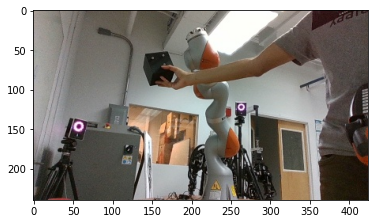

In [57]:
with torch.no_grad():
    img, label, _ = dl.get_data(np.random.randint(500))
    pred = net(img.float())
    print(pred, label, torch.linalg.norm(pred - label))
    box = ToPILImage()(img[0][:3])
    plt.imshow(box)